# Independent Component Analysis (ICA)

Copyright (c) 2019 OERCompBiomed (UiB)

Independent component analysis is a decomposition technique used to identify independent sources from a mixture (or rather multiple mixes) of signals. For instance, when you find yourself in a party, your ears don't have a separate channel for each voice, but receive a single concoction of sounds from a whole array of sources.

ICA can be done for any type of data: visual, time series, tabular data. The only requirement is for the data to be fed into the algorithm in a given shape. Here we will use the example of images for illustration. In practice, ICA is used in denoising, and for identifying independent brain networks from fMRI and EEG scans.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import FastICA

In [28]:
np.set_printoptions(precision=3)

#### Provided a mixture of signals, are you able to separate them into the originals?

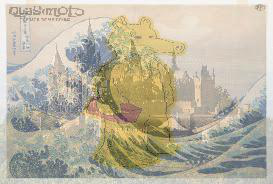

In [3]:
Image.open('assets/blended.jpg')

Perhaps it becomes easier if you are given more than one mixture. This is exactly what ICA does.

### Load images with PIL

In [4]:
filenames = ['assets/castle.jpg', 'assets/quas.jpg', 'assets/wave.jpg']
im1,im2,im3 = [Image.open(fn) for fn in filenames]

In [5]:
# image dimensions
for im in (im1,im2,im3):
    print(im.size)

(1200, 900)
(1200, 1200)
(273, 184)


#### Resize all images to the same size

In [6]:
imgs = (im1,im2,im3)
smallest_index = np.argmin([np.prod(im.size) for im in imgs])

In [7]:
type(im1)

PIL.JpegImagePlugin.JpegImageFile

#### Exercise 1. Given this information, resize all images to fit the smallest image.
Hint: use the Tab trick to find the necessary method.

In [8]:
# %load solutions/3_1.py
# resize according to smallest image
sz = imgs[smallest_index].size
im1 = im1.resize(sz)
im2 = im2.resize(sz)

In [9]:
# should print 3 identical tuples
for im in (im1,im2,im3):
    print(im.size)

(273, 184)
(273, 184)
(273, 184)


#### Display images

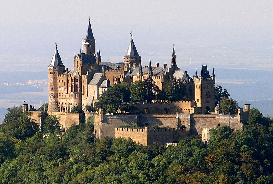

In [10]:
im1

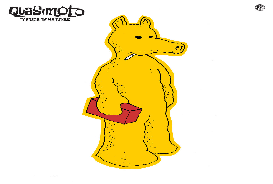

In [11]:
im2

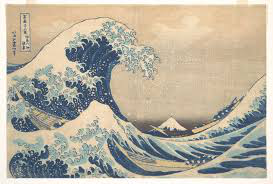

In [12]:
im3

### Greyscale for simplicity

In [13]:
from PIL import ImageOps

gim1,gim2,gim3 = [ImageOps.grayscale(im) for im in (im1,im2,im3)]

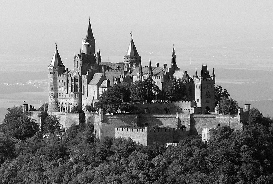

In [14]:
gim1

### Reshape and stack the images

ICA requires our whole dataset to be fed as a (NxD) matrix, in which each image is a column.

In [15]:
S = []
for i, pic in enumerate((gim1,gim2,gim3)):
    s = np.ravel(pic)
    S.append(s)
    
S = np.asarray(S).T

In [16]:
S.shape # 3 images, each of which has 50232 pixels

(50232, 3)

In [17]:
S

array([[221, 255, 251],
       [221, 255, 250],
       [224, 255, 251],
       ...,
       [ 10, 255, 241],
       [ 18, 255, 238],
       [  8, 255, 239]], dtype=uint8)

#### Make linear combination of images

Now we make linear combinations of the images. We do it 3 times (image having 3 microphones in a crowded rooms filled with conversations)

In [25]:
# mixing matrix
A = np.random.randn(3,3)

# mixed data
X = S @ A.T

In [19]:
#image = Image.blend(im1, im2, .5)
#image = Image.blend(image, im3, .5)
#image.save('blended.jpg')

#### Display the linear combinations

In [20]:
scaler = MinMaxScaler(feature_range=(0, 255))

# our images are currently strecthed out, so we must reshape them.
def plot(X, i):
    m1 = X[:,i]
    m1 = scaler.fit_transform(m1.reshape(-1,1))
    plt.imshow(m1.reshape(sz[::-1]), cmap='gray'); plt.show()

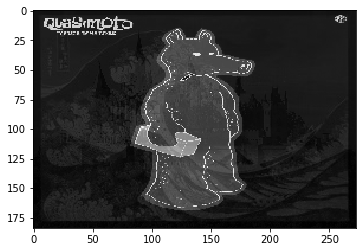

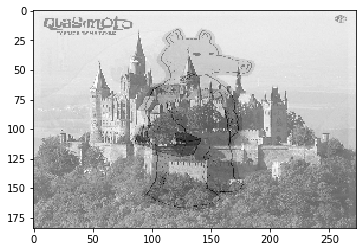

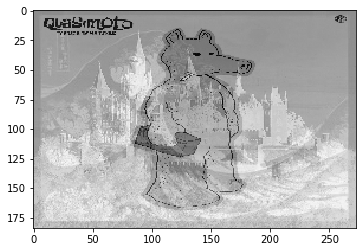

In [21]:
for i in range(A.shape[0]): plot(X, i)

The above is all our algorithm will be able to see. It has no gain to the original separated images.

#### Rescale the images before doing ICA
Standardizing is a necessary step prior to many ML algorithms 

In [30]:
np.mean(X), np.std(X)

(-119.99436621156778, 181.4902245892269)

In [31]:
X_standard_scaler = StandardScaler()
X = X_standard_scaler.fit_transform(X)

In [33]:
np.mean(X), np.std(X)

(-7.212176624586247e-15, 1.0000000000000018)

## Do the ICA

In [34]:
ica = FastICA(n_components=3, random_state=1)
S_ = ica.fit_transform(X)  # estimated sources
#A_ = ica.mixing_  # estimated mixing matrix

### Inspect the reconstructions

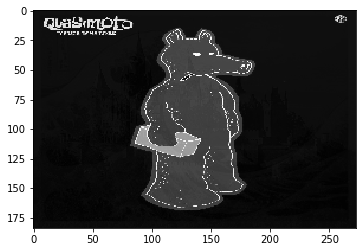

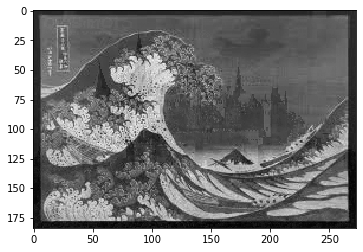

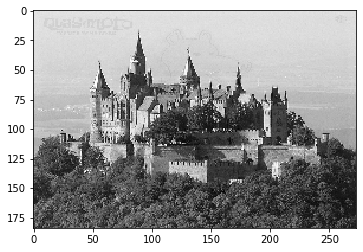

In [35]:
for i in range(3): plot(S_,i)

### And compare them to the originals

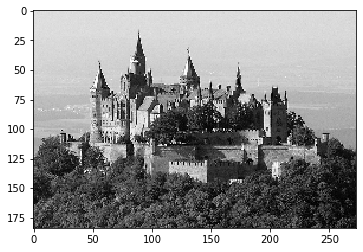

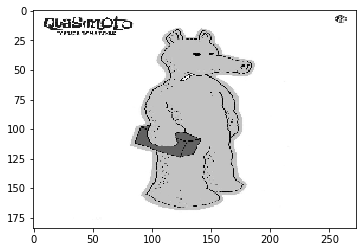

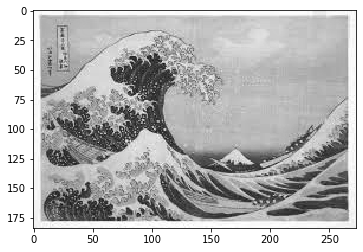

In [37]:
for i in range(3): plot(S,i)

You may experience that the reconstructions have inverted colors to the original. This is a feature of ICA that it cannot discern the sign. So ignoring this, how did the algorithm do? Are they seperated well enough?

In [55]:
### experiment: can you reapply it to yield even better results?

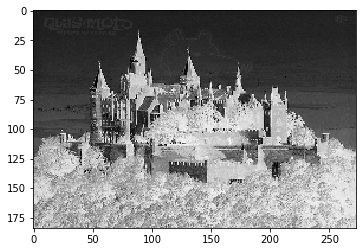

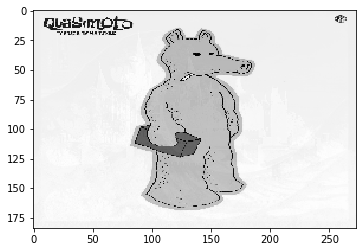

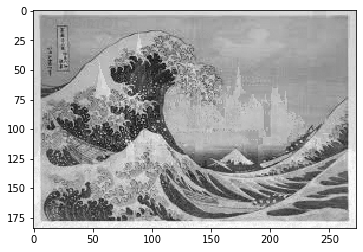

In [57]:
ica = FastICA(n_components=3, random_state=0, fun='logcosh')
S_ = ica.fit_transform(S_)  # estimated sources
for i in range(3): plot(S_, i)

# ICA and Neuroscience 

One of the most relevant medical use cases for ICA is in functional brain imaging. ICA is used both for EEG/MEG recordings as well as fMRI: any time series data of assumed overlapping signals. Especially EEG is spacially unspecific (signals are very "leaky"), such that any measured point is a combination of signals from various regions. In resting state (i.e. subjects are resting and not doing any particular task) fMRI it is used to derive spatial maps (independent components, ICs) which we refer to as resting state networks. Despite being identified from subjects at rest, these spatially continuous maps correspond largely to functionally coherent systems, such as the early visual system, the sensorimotor system etc. 

In [1]:
# nilearn stuff here